In [1]:
import os
import numpy as np
from datetime import datetime
import dill
import torch
from torch import nn
import torch.nn.functional as F
import lovely_tensors as lt
lt.monkey_patch()

import csng
from csng.models.inverted_encoder import InvertedEncoder, InvertedEncoderBrainreader
from csng.models.ensemble import EnsembleInvEnc
from csng.utils.mix import seed_all
from csng.utils.data import standardize, normalize, crop
from csng.utils.comparison import find_best_ckpt, load_decoder_from_ckpt, plot_reconstructions, plot_metrics, eval_decoder
from csng.losses import get_metrics
from csng.data import get_dataloaders, get_sample_data
from csng.brainreader_mouse.encoder import get_encoder as get_encoder_brainreader

In [2]:
### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

In [3]:
### global config
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "crop_wins": dict(),
}

### brainreader mouse data
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    # "batch_size": 1,
    "batch_size": 16,
    # "sessions": list(range(1, 3)),
    "sessions": [6],
    "resize_stim_to": (36, 64),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,

    # "neuron_coords": {
    #     "1": encoder.decoders[0].encoder.readout["6"].mu[0,:,0].detach().clone(),
    # }
}

config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
            # os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
            # os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
            # os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
            # os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
        ],
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 5,
        "seed": config["seed"],
        "use_cache": False,
    },
    "crop_win": (22, 36),
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

# add crop_wins for brainreader mouse data
dls, neuro_coords = get_dataloaders(config=config)

In [4]:
b = next(iter(dls["val"]["brainreader_mouse"]))

In [ ]:
_b

In [ ]:
b

In [ ]:
enc_ckpt = torch.load(os.path.join(DATA_PATH, "models", "encoder_ball.pt"), pickle_module=dill)
enc_ckpt["model"].readout["1.mu"]

In [ ]:
encoder = EnsembleInvEnc(
    encoder_paths=[
        os.path.join(DATA_PATH, "models", "encoder_ball.pt"),
    ],
    encoder_config={
        "img_dims": (1, 36, 64),
        "stim_pred_init": "randn",
        "lr": 1000,
        "n_steps": 1000,
        "img_grad_gauss_blur_sigma": 1.5,
        "jitter": None,
        "mse_reduction": "per_sample_mean_sum",
        "device": config["device"],
    },
    use_brainreader_encoder=True,
    get_encoder_fn=get_encoder_brainreader,
    device=config["device"],
)

In [ ]:
encoder.decoders[0].encoder.readout["1"].shared_grid

In [ ]:
encoder.decoders[0].encoder.readout["1"].mu.detach().cpu()

In [ ]:
encoder.decoders[0].encoder.readout["1"].sample_grid(batch_size=1, sample=False) == encoder.decoders[0].encoder.readout["1"].mu

## MonkeySee

In [13]:
from monkeysee.SpatialBased.train_spatial_torch import compute_mean_std, get_RFs, get_inputs
from monkeysee.SpatialBased.generator import Generator
from csng.utils.mix import update_config_paths

In [ ]:
from monkeysee.SpatialBased.train_spatial_torch import compute_mean_std, get_RFs, get_inputs
from monkeysee.SpatialBased.generator import Generator
from csng.utils.mix import update_config_paths


class MonkeySeeDecoder(nn.Module):
    def __init__(self, ckpt_dir, train_dl, new_data_path=None):
        super().__init__()


        self.ckpt_dir = ckpt_dir
        ckpt = torch.load(os.path.join(ckpt_dir, "generator.pt"), pickle_module=dill)
        self.cfg = ckpt["config"]

        if new_data_path is not None:
            update_config_paths(self.cfg, new_data_path=new_data_path)
            self.cfg["rfs"]["spatial_embeddings_path"] = os.path.join(
                new_data_path, "monkeysee", "spatial_embedding",
                self.cfg["rfs"]["spatial_embeddings_path"].split("/")[-2],
                self.cfg["rfs"]["spatial_embeddings_path"].split("/")[-1],
            )

        ### load RFs
        seed_all(self.cfg["seed"])
        self.RFs = get_RFs(**self.cfg["rfs"])

        ### initialize model
        seed_all(self.cfg["seed"])
        self.generator = Generator(**self.cfg["decoder"]["gen"], device=self.cfg["device"])
        print(f"[INFO] Generator: {self.generator}")

        ### load checkpoints
        print(f"[INFO] Loading checkpoint from {self.cfg['decoder']['load_ckpt']} ...")
        self.generator.load_state_dict(ckpt["state_dict"])

        ### collect statistics
        self.transform_inputs = lambda x: x
        if self.cfg["decoder"]["standardize_inputs"]:
            print("[INFO] Collecting statistics ...")
            # dls, _ = get_dataloaders(config=cfg)
            # train_dl = dls["train"]["brainreader_mouse"]
            mean, std = compute_mean_std(dl=train_dl, config=self.cfg, RFs=self.RFs)
            print(f"  mean: {mean}\n  std: {std}")
            self.mean = mean.unsqueeze(-1).unsqueeze(-1)
            self.std = std.unsqueeze(-1).unsqueeze(-1)
            self.transform_inputs = lambda x: (x - self.mean) / (self.std + 1e-6)

    def forward(self, x, neuron_coords=None, pupil_center=None):
        inputs = get_inputs(brains=x, config=self.cfg, transform_inputs_fn=self.transform_inputs, RFs=self.RFs)
        recons = self.generator(inputs, return_inv_ret_maps=False)
        return recons

In [10]:
model = MonkeySeeDecoder(
    ckpt_dir=os.path.join(DATA_PATH, "monkeysee", "runs", "13-02-2025_11-47"),
    train_dl=get_dataloaders(config=config)[0]["train"]["brainreader_mouse"],
    new_data_path=DATA_PATH,
)

[INFO] Generator: Generator(
  (_network): Network(
    (main): Sequential(
      (0): Conv2d(480, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (layer): Skip(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
          (3): Skip(
            (block): Sequential(
              (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): LeakyReLU(negative_slope=0.2, inplace=True)
              (3): Skip(
                (block): Sequential(
                  (0): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
           

100%|██████████| 141/141 [00:08<00:00, 16.16it/s]

  mean: tensor[480] x∈[-0.008, 0.007] μ=0.000 σ=0.002 cuda:0
  std: tensor[480] x∈[2.024, 40.024] μ=3.145 σ=1.781 cuda:0


In [ ]:
ckpt_dir = os.path.join(DATA_PATH, "monkeysee", "runs", "13-02-2025_11-47")

ckpt = torch.load(os.path.join(ckpt_dir, "generator.pt"), pickle_module=dill)
cfg = ckpt["config"]
cfg["rfs"]["spatial_embeddings_path"] = os.path.join(
    DATA_PATH, "monkeysee", "spatial_embedding",
    cfg["rfs"]["spatial_embeddings_path"].split("/")[-2],
    cfg["rfs"]["spatial_embeddings_path"].split("/")[-1],
)
cfg

In [ ]:
from csng.utils.mix import update_config_paths
update_config_paths(cfg, DATA_PATH)

In [ ]:
### prepare data
seed_all(cfg["seed"])
RFs = get_RFs(**cfg["rfs"])

### initialize models
seed_all(cfg["seed"])
generator = Generator(**cfg["decoder"]["gen"], device=cfg["device"])
print(f"[INFO] Generator: {generator}")

### load checkpoints
print(f"[INFO] Loading checkpoint from {cfg['decoder']['load_ckpt']} ...")
generator.load_state_dict(ckpt["state_dict"])
history = ckpt["history"]

### collect statistics
transform_inputs = lambda x: x
if cfg["decoder"]["standardize_inputs"]:
    print("[INFO] Collecting statistics ...")
    dls, _ = get_dataloaders(config=cfg)
    train_dl = dls["train"]["brainreader_mouse"]
    mean, std = compute_mean_std(dl=train_dl, config=cfg, RFs=RFs)
    print(f"  mean: {mean}\n  std: {std}")
    mean = mean.unsqueeze(-1).unsqueeze(-1)
    std = std.unsqueeze(-1).unsqueeze(-1)
    transform_inputs = lambda x: (x - mean) / (std + 1e-6)

val. VGG: 1.6711
  val. L1: 0.8341


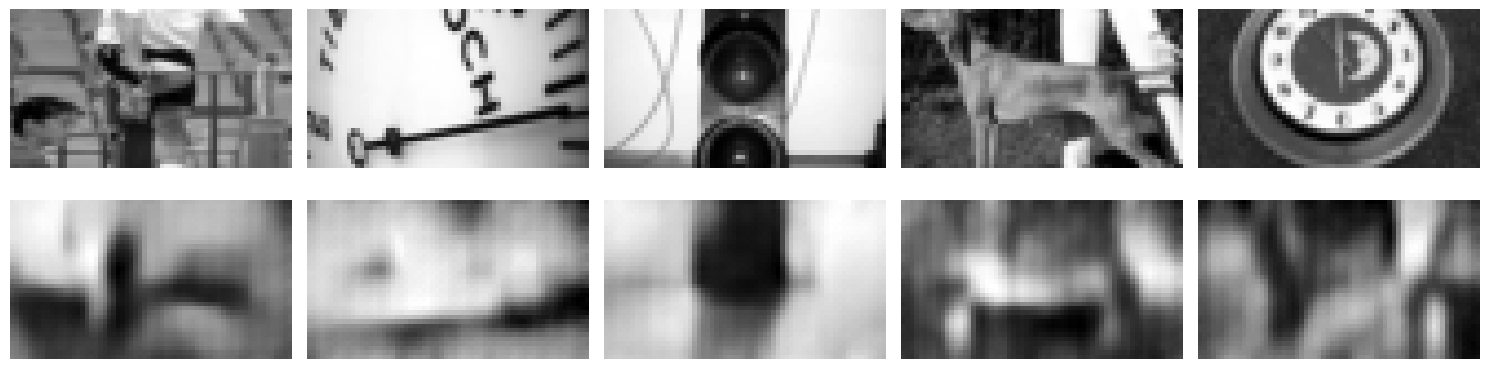

In [14]:
cfg = model.cfg
dls, _ = get_dataloaders(config=cfg)
val_dl = dls["val"]["brainreader_mouse"]

### eval generator
model.eval()
with torch.no_grad():
    vgg_loss, l1_loss, n_samples = 0, 0, 0
    for batch in val_dl:
        brains = torch.cat([dp["resp"] for dp in batch], dim=0).unsqueeze(-1).to(cfg["device"])
        targets = torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"])
        # inputs = get_inputs(brains=brains, config=cfg, transform_inputs_fn=transform_inputs, RFs=RFs)

        # recons, inv_ret_maps = generator(inputs, return_inv_ret_maps=True)
        recons = model(x=brains)

        _vgg_loss = model.generator._lossfun._vgg(recons, targets, reduction="none")
        vgg_loss += torch.stack([vgg_layer_loss.mean(dim=(1, 2, 3)) for vgg_layer_loss in _vgg_loss], dim=1).mean(dim=1).sum().item()
        l1_loss += F.l1_loss(recons, targets, reduction="none").mean(dim=(1, 2, 3)).sum().item()
        n_samples += len(recons)
    vgg_loss /= n_samples
    l1_loss /= n_samples
    print(f"val. VGG: {vgg_loss:.4f}\n  val. L1: {l1_loss:.4f}")

### plot reconstructions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 6))
for i in range(min(5, len(recons))):
    ax = fig.add_subplot(3, min(5, len(recons)), i+1)
    ax.imshow(targets[i].cpu().numpy().squeeze(), cmap='gray')
    ax.axis('off')
    ax = fig.add_subplot(3, min(5, len(recons)), i+min(5, len(recons))+1)
    ax.imshow(recons[i].cpu().numpy().squeeze(), cmap='gray')
    ax.axis('off')
    if cfg["decoder"]["gen"]["inverse_retinotopic_mapping_cfg"] is not None:
        if inv_ret_maps.size(1) == 1:
            ax = fig.add_subplot(3, min(5, len(recons)), i+2*min(5, len(recons))+1)
            ax.imshow(inv_ret_maps[i].cpu().numpy().squeeze(), cmap='gray')
            ax.axis('off')
        else:
            ax = fig.add_subplot(3, min(5, len(recons)), i+2*min(5, len(recons))+1)
            ax.imshow(inv_ret_maps[i][i].unsqueeze(0).cpu().numpy().squeeze(), cmap='gray')
            ax.axis('off')
fig.tight_layout()
plt.show()